# Setup

In [1]:
from tensorflow import keras
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os
import sklearn

In [5]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
# keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# **CAN(Controller Area Network) 데이터를 활용한 변속 이상 탐지**

## **0. 프로젝트 설명**

### **문제 상황**



+ 홍길동씨는 새로운 차량을 구입한 후 1년 동안 아무 문제 없이 주행했습니다.
+ 1년이 지난 어느 날, **변속 지점**에서 **간헐적으로 이상한 느낌**을 받게 되어, 정비센터를 방문했습니다.
+ 자동차정비 엔지니어는 문제를 파악하기 위해 차량을 한 바퀴 운전해 보았으나, 현상이 나타나지 않았습니다.
+ **문제를 재현하기 위해** 엔지니어는 **48시간 동안 직접 운전**하며 **이상 지점을 체크**했고, **기어가 한 단계 내려갈 때** 간헐적으로 발생했습니다.
+ 장시간 동안 시험을 반복하다 보니 정비 엔지니어가 과로로 쓰러졌습니다.
+ **현상을 파악하는 데 많은 작업 시간과 인력이 필요**했으며, 모든 차량을 일일이 운전하며 이상 지점을 체크하는 것은 매우 어려운 상황입니다.

### **문제 정의**

+ 본 프로젝트의 목표는 **딥러닝 기술을 활용하여 변속 이상 지점을 탐지**할 수 있는 모델을 개발하는 것입니다.
+ 1년 동안 정상적으로 주행한 데이터를 이용해서 Anomaly score를 출력하는 딥러닝 모델을 설계하고자 합니다.

## **1. 데이터 준비**

### Google Drive 연동 및 데이터 다운로드

In [ ]:
# Google Drive 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# CAN 데이터 다운로드

#Train
!wget -O CAN_AnomalyDetection.zip https://www.dropbox.com/scl/fi/ami7gzy4jqvhi98e2azez/CAN_AnomalyDetection.zip?rlkey=ljzbz14jcfhqh5dnnxpm4ybat&dl=0

try:
    os.makedirs('/content/CAN/dataset')
except:
    pass

!unzip -qo /content/CAN_AnomalyDetection.zip -d /content/CAN/dataset

--2024-06-17 07:37:17--  https://www.dropbox.com/scl/fi/ami7gzy4jqvhi98e2azez/CAN_AnomalyDetection.zip?rlkey=ljzbz14jcfhqh5dnnxpm4ybat
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1be874d9252fa23bb8551e71d3.dl.dropboxusercontent.com/cd/0/inline/CU-uiJkUYLxBkMOxDvIYVfYuxN_fa73gUSKWGKCW0rzmXRjkrKhmG0kUJ38zN62YJ4zT2ZNMu6-Dx9AGov4LeG2NZ2Vx7hgZkKznyIijBYyWqpHzohw61dhgtbjk_Pc_zOjN4ckFdi4x52TQu-xlW_ZB/file# [following]
--2024-06-17 07:37:18--  https://uc1be874d9252fa23bb8551e71d3.dl.dropboxusercontent.com/cd/0/inline/CU-uiJkUYLxBkMOxDvIYVfYuxN_fa73gUSKWGKCW0rzmXRjkrKhmG0kUJ38zN62YJ4zT2ZNMu6-Dx9AGov4LeG2NZ2Vx7hgZkKznyIijBYyWqpHzohw61dhgtbjk_Pc_zOjN4ckFdi4x52TQu-xlW_ZB/file
Resolving uc1be874d9252fa23bb8551e71d3.dl.dropboxusercontent.com (uc1be874d9252fa23bb8551e71d3.dl.dropboxusercontent.com)... 162.12

### 실습 데이터 설명

+ CAN 데이터는 차량의 다양한 센서로부터 수집되는 데이터입니다.

+ 다양한 주기로 수집되기 때문에 각 센서 데이터의 타임스탬프가 일치하지 않을 수 있습니다.

**CAN Data 예시**


<img src = "https://www.dropbox.com/scl/fi/rt1ecomq9k129vbtxlxfk/CAN_ex.png?rlkey=by6ng4ke33w2j47je3qn7tuag&raw=1" width="800" height ="" /><br>


In [6]:
DF_list = [pd.read_csv(os.path.join('CAN_AnomalyDetection', file), low_memory=False)
           for file in os.listdir('CAN_AnomalyDetection/') if file.endswith('.csv')]

In [58]:
# 원본 CAN 데이터를 df_list에 복제
import copy
df_list = copy.deepcopy(DF_list)

In [73]:
# 데이터 예시 출력
Ex_df = copy.deepcopy(df_list[0])
Ex_df

,Timestamp,TarGear,LatAccel,LongAccel,YawRate,SAS,EngStat,BrkDep,AccDep,EngRPM,WhlSpdFL,WhlSpdFR,WhlSpdRL,WhlSpdRR,EngColTemp,VehSpdClu
0,1.694502e+09,4th speed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.694502e+09,NaN,NaN,NaN,NaN,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.694502e+09,NaN,0.48,-0.37,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.694502e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,46.03125,45.53125,45.71875,NaN,NaN
4,1.694502e+09,NaN,NaN,NaN,NaN,NaN,ES(Engine Stop),10.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275474,1.694504e+09,2nd speed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275475,1.694504e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0
275476,1.694504e+09,NaN,NaN,NaN,NaN,18.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275477,1.694504e+09,NaN,0.00,-1.96,1.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **2. 데이터 전처리**



**결측치 처리**
+ 센서별로 수집 주기가 다르기 때문에 데이터를 시간 순으로 정렬하면 결측치가 발생합니다.
+ 결측치를 보간이나 대체 등의 방법을 이용하여 처리해주어야 합니다.

**범주형 데이터 변경**
+ 딥러닝 모델은 숫자형 데이터를 입력 받습니다.
+ 문자열로 표현된 범주형 데이터를 숫자형으로 변환하여 모델이 데이터를 처리할 수 있도록 합니다.

**시간축 재설정**
+ 모델이 시간 순서에 따른 패턴을 학습할 수 있도록 일정한 간격으로 샘플링해야 합니다.
+ 다양한 주기로 수집된 데이터를 일정한 간격으로 재샘플링하여 타임스탬프를 동기화 합니다.

**변속 구간 추출**
+ 변속 전후 구간을 학습하여 변속과 관련된 정상 패턴을 학습하고, 이를 통해 비정상적인 변속 패턴을 감지할 수 있도록 합니다.
+ 변속 전 0.5초, 변속 후 2초의 구간을 선택하여 추출합니다.

**데이터 스케일링**
+ 각 센서 데이터의 범위가 다르기 때문에 값의 크기 차이가 큰 경우 모델이 특정 변수에 더 큰 가중치를 부여할 수 있습니다.
+ 데이터 스케일링을 통해 변수의 값을 일정한 범위로 설정하여 특정 변수에 지나치게 의존하지 않도록 합니다.



### **1) 결측치 처리**

+ 칼럼별로 보간, 대체 등의 방법을 이용하여 결측치 처리
+ Dataframe을 입력받아 결측치 처리된 Dataframe을 반환하는 **handle_missing_values** 함수 작성

In [74]:
def handle_missing_values(df):
    df = df.fillna(method='ffill').dropna(axis=0).reset_index(drop=True)

    return df

In [75]:
# 결측치 처리
Ex_df = handle_missing_values(Ex_df)

In [47]:
#결측치 처리 확인
assert not Ex_df.isnull().values.any(), "dataframe contains NaN values"

In [48]:
# 데이터 예시 출력
Ex_df.head()

,Timestamp,TarGear,LatAccel,LongAccel,YawRate,SAS,EngStat,BrkDep,AccDep,EngRPM,WhlSpdFL,WhlSpdFR,WhlSpdRL,WhlSpdRR,EngColTemp,VehSpdClu
0,1.694502e+09,4th speed,0.23,-0.41,0.21,1.2,ES(Engine Stop),11.0,0.0,0.0,46.21875,46.03125,45.875,45.53125,55.5,45.0
1,1.694502e+09,4th speed,0.23,-0.41,0.21,1.2,ES(Engine Stop),11.0,0.0,0.0,46.21875,46.03125,45.875,45.53125,55.5,45.0
2,1.694502e+09,4th speed,0.23,-0.41,0.21,1.2,ES(Engine Stop),11.0,0.0,0.0,46.21875,46.03125,45.875,45.53125,55.5,45.0
3,1.694502e+09,4th speed,0.25,-0.43,0.25,1.2,ES(Engine Stop),11.0,0.0,0.0,46.21875,46.03125,45.875,45.53125,55.5,45.0
4,1.694502e+09,4th speed,0.25,-0.43,0.25,1.2,ES(Engine Stop),11.0,0.0,0.0,46.21875,46.03125,45.875,45.53125,55.5,45.0


### **2) 범주형 데이터 인코딩**

+ 범주형 데이터를 숫자형 데이터로 변경
+ Dataframe을 입력받아 범주형 데이터가 인코딩된 Dataframe을 반환하는 **encode_categorical_values** 함수 작성

In [62]:
categorical_dict = {'TarGear': {'If N or P are detected(No frictional conncetion)' : 0, '1st speed' : 1, '2nd speed' : 2, '3rd speed' : 3,
                                '4th speed' : 4, '5th speed' : 5, '6th speed' : 6, 'Reverse' : 7},
                    'AccDep' : {'Accelerator Pedal not activated' : 0, 'Accelerator Pedal fully activated' : 254, 'Accelerator Pedal is defective (fail state) or Non-ETC system (APS is not installed)' : 255},
                    'EngStat': {'ES(Engine Stop)' : 0, 'ST(Start)' : 1 ,'IS(Idle speed)' : 2, 'PL(Part Load)' : 3, 'PU(Pull)' : 4, 'PUC(Fuel Cut off)' : 5 }
                    }

In [70]:
len(list(categorical_dict['TarGear'].keys()))

8

In [78]:
Ex_df = Ex_df.replace(categorical_dict)

In [80]:
tf.one_hot(Ex_df['TarGear'].values, depth = 8)

<tf.Tensor: shape=(275411, 8), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)>

In [63]:
def encode_categorical_values(df, target_columns):
    df = df.replace(categorical_dict)

    for col in target_columns:
        size = len(list(categorical_dict[col].keys()))
        one_hot_array = tf.one_hot(df[col].values, depth = size).numpy()
        one_hot_df = pd.DataFrame(one_hot_array, columns=[f'{col}_{i}' for i in range(size)])
        df = pd.concat([df, one_hot_df], axis=1)

    return df

In [ ]:
except_cols = []
for col in target_columns:
    columns = [f'{col}_{i}' for i in range(size)]
    except_cols.extend(columns)

except_df = Ex_df.loc[:,except_cols]
Scaling_df = Ex_df.drop(except_cols)

In [65]:
Ex_df = encode_categorical_values(Ex_df, ['TarGear', 'EngStat'])

In [66]:
# 데이터 예시 출력
Ex_df.head()

,Timestamp,LatAccel,LongAccel,YawRate,SAS,BrkDep,AccDep,EngRPM,WhlSpdFL,WhlSpdFR,...,TarGear_4,TarGear_5,TarGear_6,TarGear_7,EngStat_0,EngStat_1,EngStat_2,EngStat_3,EngStat_4,EngStat_5
0,1.694502e+09,0.23,-0.41,0.21,1.2,11.0,0.0,0.0,46.21875,46.03125,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.694502e+09,0.23,-0.41,0.21,1.2,11.0,0.0,0.0,46.21875,46.03125,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.694502e+09,0.23,-0.41,0.21,1.2,11.0,0.0,0.0,46.21875,46.03125,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.694502e+09,0.25,-0.43,0.25,1.2,11.0,0.0,0.0,46.21875,46.03125,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.694502e+09,0.25,-0.43,0.25,1.2,11.0,0.0,0.0,46.21875,46.03125,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


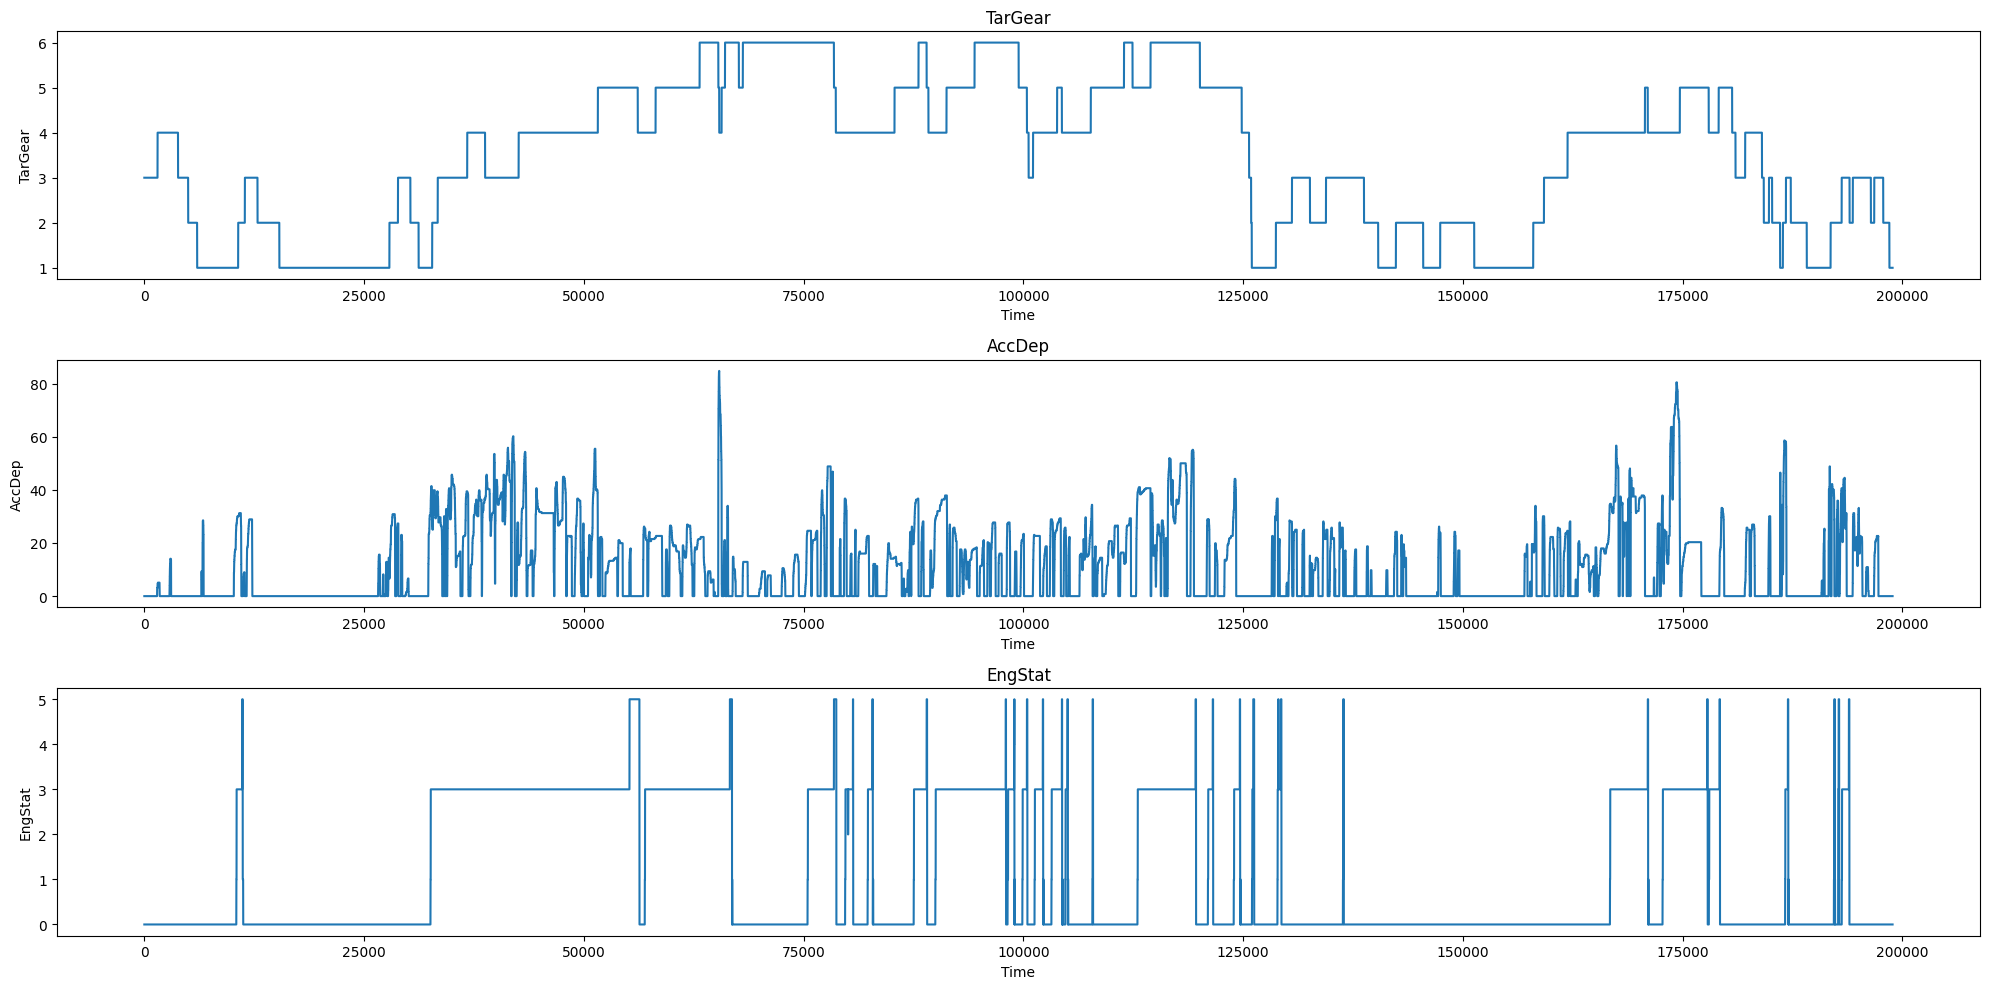

In [26]:
# 범주형 데이터 인코딩 결과 시각화
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))

# TarGear 그래프
axes[0].plot(Ex_df['TarGear'])
axes[0].set_title('TarGear')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('TarGear')

# AccDep 그래프
axes[1].plot(Ex_df['AccDep'])
axes[1].set_title('AccDep')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('AccDep')


# EngStat 그래프
axes[2].plot(Ex_df['EngStat'])
axes[2].set_title('EngStat')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('EngStat')
plt.tight_layout()
plt.show()

### **3) 시간축 재설정**

<img src = "https://www.dropbox.com/scl/fi/cojsvm4rucfvh1o7xjshx/resampling.png?rlkey=b4m1f7jjot4qszoc9wep9e3zi&raw=1" width="1000" height ="" /><br>

---

<img src = "https://www.dropbox.com/scl/fi/mi8dk48z80lpg12hrkddl/resampling2.png?rlkey=y9wlizn604l7bhhji2o1pwmrz&raw=1" width="1000" height ="" /><br>

---
+ 다양한 주기로 수집된 데이터를 일정한 간격으로 재샘플링
+ Dataframe과 sampling_time을 입력받아 재샘플링된 Dataframe을 반환하는 **resampling** 함수 작성

In [27]:
def get_resampled_data(df, sampling_time):
    '''처음과 끝 시간 저장'''
    start_time = df.loc[0, 'Timestamp']
    end_time = df.loc[len(df)-1,'Timestamp']

    '''sampling_time 간격으로 처음과 끝 시간 사이를 나눔'''
    new_timestamp = np.arange(start_time, end_time, sampling_time)

    '''
        data resampling
        1. np.searchsorted 함수를 통해, new_timestamp의 시간 t에 해당하는 값은
            기존 timestamp의 몇 번 index에 놓여지는지 추출

            ex) [1.1, 1.2, 2.1, 5.1]의 각 값은 [1,2,3,4,5]의 몇 번 index에 들어가야하는가?
            코드    : print(np.searchsorted(np.array([1,2,3,4,5]), np.array([1.1, 1.2, 2.1, 5.1]), side='right'))
            출력 값 : [1 1 2 5]
            참조    : https://numpy.org/doc/stable/reference/generated/numpy.searchsorted.html

        2. np.searchsorted 함수의 출력 array 전체 값에 1을 빼주어, 시간 t 기준
            가장 가까운 과거를 나타내는 index 추출
        3. 추출한 index를 통해 값 추출 : resample 완료
    '''
    indices = np.searchsorted(df['Timestamp'].values, new_timestamp, side='right') - 1

    df_resample = df.loc[indices].reset_index(drop=True) # index를 통해 값 추출
    df_resample['Timestamp'] = new_timestamp # 기존 timestamp를 new_timestamp로 대체

    df = df_resample # resample한 data 저장

    # print("Resampling Finished.")

    return df

In [28]:
Ex_df = get_resampled_data(Ex_df, 0.01)

In [29]:
# 데이터 예시 출력
Ex_df.head()

,Timestamp,TarGear,LatAccel,LongAccel,YawRate,SAS,EngStat,BrkDep,AccDep,EngRPM,WhlSpdFL,WhlSpdFR,WhlSpdRL,WhlSpdRR,EngColTemp,VehSpdClu
0,1.716463e+09,3,0.80,-1.0,0.90,3.7,0,22.0,0,0.0,44.09375,43.96875,43.96875,43.9375,43.5,43.0
1,1.716463e+09,3,0.80,-1.0,0.90,3.7,0,22.0,0,0.0,44.09375,43.96875,43.96875,43.9375,43.5,43.0
2,1.716463e+09,3,0.62,-1.0,0.93,3.7,0,22.0,0,0.0,44.09375,43.96875,43.96875,43.9375,43.5,43.0
3,1.716463e+09,3,0.62,-1.0,0.93,3.5,0,22.0,0,0.0,43.71875,44.06250,43.78125,43.8125,43.5,43.0
4,1.716463e+09,3,0.62,-1.0,0.93,3.5,0,22.0,0,0.0,43.71875,44.06250,43.78125,43.8125,43.5,43.0


In [30]:
# time 열의 앞뒤 차이 계산
time_diff = (Ex_df['Timestamp'] - Ex_df['Timestamp'].shift(1)).to_frame(name='time_diff')
# 결과 출력
time_diff

,time_diff
0,NaN
1,0.01
2,0.01
3,0.01
4,0.01
...,...
136214,0.01
136215,0.01
136216,0.01
136217,0.01


### **4) 변속 구간 추출**

+ 변속 전후로 적절한 구간을 선택하여 추출(기어가 한 단계 낮아진 경우)
+ Dataframe을 입력받아 변속 구간이 추출된 shift_df_list를 반환하는 **get_shift_data** 함수 작성
    - down_shift는 [cur_gear - prev_gear]값이 -1 일 때의 index임
    - down_idx 기준 50 timestep 이전, 200 timestep 이후 시퀀스를 추출하여 (250, 칼럼 개수) 가 되도록 함

In [31]:
def get_shift_data(df):
    shift_df_list = []
    prev_gear = df['TarGear'].values[:-1]
    cur_gear = df['TarGear'].values[1:]
    shift = cur_gear - prev_gear
    # df.drop 추가
    down_shift = np.where(shift == -1)[0]
    for down_idx in down_shift:
        if down_idx >= 50 and (down_idx + 200) < len(df):
            sub_df = df[(down_idx-50):(down_idx+200)].copy().reset_index(drop=True)
            shift_df_list.append(sub_df)

    return shift_df_list

In [32]:
# 변속 구간 추출
shift_df_list = get_shift_data(Ex_df)

In [33]:
# 데이터 예시 출력
shift_df_list[0]

,Timestamp,TarGear,LatAccel,LongAccel,YawRate,SAS,EngStat,BrkDep,AccDep,EngRPM,WhlSpdFL,WhlSpdFR,WhlSpdRL,WhlSpdRR,EngColTemp,VehSpdClu
0,1.716463e+09,4,-0.43,-0.88,-1.14,-3.6,0,21.0,0,0.0,47.50000,47.125,47.40625,47.12500,42.75,47.0
1,1.716463e+09,4,-0.43,-0.88,-1.14,-3.5,0,21.0,0,0.0,47.50000,47.125,47.40625,47.12500,42.75,47.0
2,1.716463e+09,4,-0.14,-0.71,-1.01,-3.5,0,21.0,0,0.0,47.50000,47.125,47.40625,47.12500,42.75,47.0
3,1.716463e+09,4,-0.14,-0.71,-1.01,-3.5,0,21.0,0,0.0,47.50000,47.125,47.40625,47.12500,42.75,47.0
4,1.716463e+09,4,-0.44,-0.81,-1.04,-3.5,0,21.0,0,0.0,47.50000,47.125,47.40625,47.12500,42.75,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1.716463e+09,3,0.82,-0.57,4.85,17.7,0,10.0,0,0.0,41.03125,41.625,40.93750,41.53125,42.75,41.0
246,1.716463e+09,3,0.79,-0.49,4.78,17.7,0,11.0,0,0.0,41.03125,41.625,40.93750,41.53125,42.75,41.0
247,1.716463e+09,3,0.79,-0.49,4.78,17.7,0,11.0,0,0.0,41.03125,41.625,40.93750,41.53125,42.75,41.0
248,1.716463e+09,3,0.71,-0.46,4.74,17.7,0,11.0,0,0.0,41.03125,41.625,40.93750,41.53125,42.75,41.0


### **5) 데이터 스케일링**

+ 정규화 또는 표준화를 통해 데이터를 일정한 범위로 설정
+ df_list와 scaler를 입력받아 스케일링된 df_list와 scaler를 반환하는 **get_scaled_data**  함수 작성

In [34]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def get_scaled_data(df_list, Scaler):
    scaler = Scaler

    # 모든 데이터프레임을 결합하여 스케일러 학습
    combined_df = pd.concat(df_list)
    combined_df.drop(['Timestamp'], axis=1, inplace = True)
    columns = combined_df.columns
    scaler.fit(combined_df[columns].values)

    # 각 데이터프레임에 대해 스케일링 적용
    for i, df in enumerate(df_list):
        df.drop(['Timestamp'], axis=1, inplace = True)
        df[columns] = scaler.transform(df[columns].values)
        df_list[i] = df

    return df_list, scaler

In [35]:
# 데이터 스케일링
Ex_MinMaxScaler = MinMaxScaler()
Ex_StandardScaler = StandardScaler()
Ex_df_list, Ex_scaler = get_scaled_data(shift_df_list, Ex_MinMaxScaler) 

In [36]:
# 데이터 예시 출력
Ex_df_list[0]

,TarGear,LatAccel,LongAccel,YawRate,SAS,EngStat,BrkDep,AccDep,EngRPM,WhlSpdFL,WhlSpdFR,WhlSpdRL,WhlSpdRR,EngColTemp,VehSpdClu
0,0.6,0.593968,0.501006,0.694094,0.886355,0.0,0.259259,0.0,0.0,0.500660,0.497358,0.501490,0.500332,0.043478,0.50000
1,0.6,0.593968,0.501006,0.694094,0.886717,0.0,0.259259,0.0,0.0,0.500660,0.497358,0.501490,0.500332,0.043478,0.50000
2,0.6,0.661253,0.535211,0.699389,0.886717,0.0,0.259259,0.0,0.0,0.500660,0.497358,0.501490,0.500332,0.043478,0.50000
3,0.6,0.661253,0.535211,0.699389,0.886717,0.0,0.259259,0.0,0.0,0.500660,0.497358,0.501490,0.500332,0.043478,0.50000
4,0.6,0.591647,0.515091,0.698167,0.886717,0.0,0.259259,0.0,0.0,0.500660,0.497358,0.501490,0.500332,0.043478,0.50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.4,0.883991,0.563380,0.938086,0.963446,0.0,0.123457,0.0,0.0,0.432388,0.439234,0.432969,0.440864,0.043478,0.43617
246,0.4,0.877030,0.579477,0.935234,0.963446,0.0,0.135802,0.0,0.0,0.432388,0.439234,0.432969,0.440864,0.043478,0.43617
247,0.4,0.877030,0.579477,0.935234,0.963446,0.0,0.135802,0.0,0.0,0.432388,0.439234,0.432969,0.440864,0.043478,0.43617
248,0.4,0.858469,0.585513,0.933605,0.963446,0.0,0.135802,0.0,0.0,0.432388,0.439234,0.432969,0.440864,0.043478,0.43617


### **6) 데이터 전처리**

+ 전체 데이터에 대해 데이터 전처리 수행
+ df_list와 sampling_time, Scaler를 입력받아 전처리된 df_list와 scaler를 반환하는 **Preprocesser**  함수 작성

In [37]:
def Preprocesser(df_list, sampling_time, Scaler):
    shift_df_list = []
    for df in (tqdm(df_list)):

        df = handle_missing_values(df)

        df = encode_categorical_values(df)

        df = get_resampled_data(df, sampling_time)

        shift_df_list.extend(get_shift_data(df))

    df_list, scaler = get_scaled_data(shift_df_list, Scaler)

    print("\nCAN data preprocessing completed.\n")
    return df_list, scaler

In [38]:
# 학습 데이터 전처리
from sklearn.preprocessing import MinMaxScaler, StandardScaler
MinMaxScaler = MinMaxScaler()
StandardScaler = StandardScaler()

Preprocessed_df_list, scaler = Preprocesser(df_list, 0.01, MinMaxScaler) # 사용한 scaler를 받아 test 데이터 스케일링에 사용함

100%|██████████| 39/39 [00:22<00:00,  1.71it/s]



CAN data preprocessing completed.



In [39]:
# 리스트를 NumPy 배열로 변환
array_list = [df.values for df in Preprocessed_df_list]
X_train = np.stack(array_list)
print('X_train shape :', X_train.shape)

X_train shape : (2121, 250, 15)


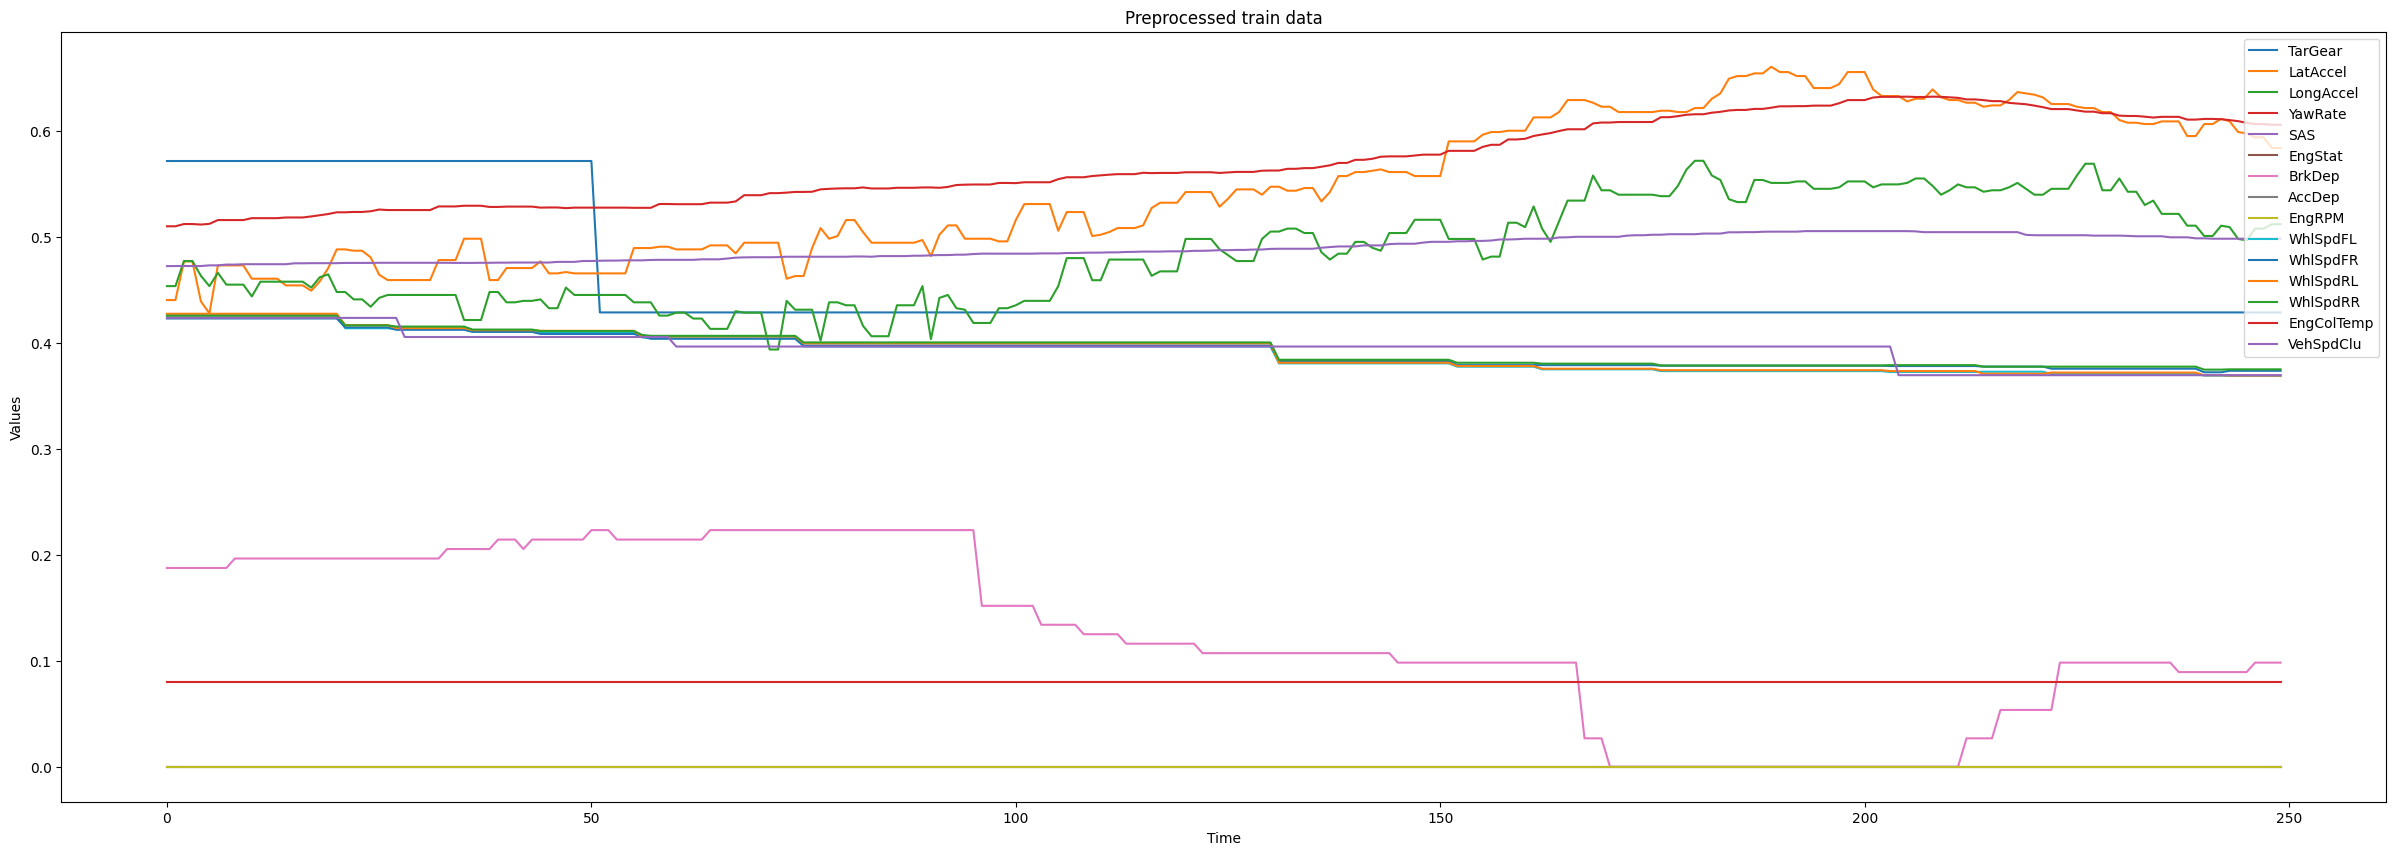

In [40]:
# 전처리 이후 데이터프레임의 각 열에 대한 그래프 예시
plt.figure(figsize=(30, 10))
for col in Preprocessed_df_list[0].columns:
    plt.plot(Preprocessed_df_list[0][col], label=col)

plt.title('Preprocessed train data')
plt.xlabel('Time')
plt.ylabel('Values')

plt.legend(loc='upper right')
plt.show()


## **4. 딥러닝 모델 설계**

### **변속 이상 탐지 방법**

+ 오토인코더를 사용하여 정상 주행 데이터를 학습시킵니다.
+ 오토인코더는 입력 데이터와 복원된 데이터 간의 오차를 최소화하도록 학습됩니다.
+ 정상 주행 데이터로 학습된 오토인코더는 정상 상태의 데이터 패턴을 잘 학습하므로, 이상 상태의 데이터는 복원 오차가 크게 나타납니다.
+ 복원 오차를 기준으로 이상 지점을 탐지할 수 있습니다.


### **학습 설정**

In [54]:
from keras.optimizers import Adam
############# Setting ##############

# 손실함수
loss = 'mean_squared_error'

# learning rate
lr = 0.0001

# 반복 횟수
EPOCHS = 300

# 배치 사이즈
BATCH_SIZE = 128



### **모델 설계**

In [55]:
from keras import Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Input, RepeatVector
# 옵티마이저
optimizer = Adam(lr)

# 오토인코더 모델 구성
latent_size = 10
n_timewindow = 250
n_feature = 15

# Encoder 설계
########### 코드 실습 ###########
encoder = Sequential(name='Encoder')
encoder.add(LSTM(latent_size, return_sequences = True, input_shape = (n_timewindow, n_feature)))
encoder.add(LSTM(latent_size))
encoder.add(RepeatVector(n_timewindow))

#################################


# Decoder 설계
########### 코드 실습 ###########
decoder = Sequential(name='Decoder')
decoder.add(LSTM(latent_size, return_sequences=True, input_shape = (n_timewindow, latent_size)))
decoder.add(LSTM(latent_size, return_sequences=True))
decoder.add(TimeDistributed(Dense(n_feature, activation='sigmoid')))
#################################

# Autoencoder 설계
########### 코드 실습 ###########
autoencoder = Sequential([encoder, decoder])
#################################

encoder.summary()
decoder.summary()
autoencoder.summary()

# Autoencoder 학습 설정
autoencoder.compile(loss=loss, optimizer=optimizer)

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250, 10)           1040      
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 repeat_vector (RepeatVecto  (None, 250, 10)           0         
 r)                                                              
                                                                 
Total params: 1880 (7.34 KB)
Trainable params: 1880 (7.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 250, 10)           840       
          

## **5. 딥러닝 모델 학습**



In [56]:
history = autoencoder.fit(X_train, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_split=0.1)

Epoch 1/300
15/15 [==============================] - 11s 140ms/step - loss: 0.0936 - val_loss: 0.0958
Epoch 2/300
15/15 [==============================] - 1s 38ms/step - loss: 0.0926 - val_loss: 0.0947
Epoch 3/300
15/15 [==============================] - 1s 39ms/step - loss: 0.0917 - val_loss: 0.0936
Epoch 4/300
15/15 [==============================] - 1s 38ms/step - loss: 0.0908 - val_loss: 0.0926
Epoch 5/300
15/15 [==============================] - 1s 39ms/step - loss: 0.0899 - val_loss: 0.0916
Epoch 6/300
15/15 [==============================] - 1s 67ms/step - loss: 0.0891 - val_loss: 0.0906
Epoch 7/300
15/15 [==============================] - 1s 65ms/step - loss: 0.0883 - val_loss: 0.0897
Epoch 8/300
15/15 [==============================] - 1s 38ms/step - loss: 0.0874 - val_loss: 0.0887
Epoch 9/300
15/15 [==============================] - 1s 39ms/step - loss: 0.0866 - val_loss: 0.0877
Epoch 10/300
15/15 [==============================] - 1s 40ms/step - loss: 0.0857 - val_loss: 0.08

## **6. 평가 및 시각화**

### **Test 데이터 다운로드**

In [57]:
# CAN 데이터 다운로드
try:
    os.makedirs('/content/CAN/Test')
except:
    pass

#Test
!wget -O /content/CAN/Test/X_test.npy https://www.dropbox.com/scl/fi/jfpcghelo7ywxa3buaxh3/X_test.npy?rlkey=e0uorq33lsowhutpbffjzm9cu&dl=0
!wget -O /content/CAN/Test/Y_test.npy https://www.dropbox.com/scl/fi/6glk769kn86gnktuvgjro/Y_test.npy?rlkey=9ovkgi02h2p52tqa6x84xnrzo&dl=0

--2024-06-17 07:46:46--  https://www.dropbox.com/scl/fi/jfpcghelo7ywxa3buaxh3/X_test.npy?rlkey=e0uorq33lsowhutpbffjzm9cu
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6f84fe947ae354319a34d92a2b.dl.dropboxusercontent.com/cd/0/inline/CU96ar9zEfvRt-iXycmXMsmkDi3QSikKINxqT7A1Dd0oTtpLq5enmORgA7tfFW2hGLR6WXedj0Qj82OlcHYVE0adpdI0FQUFfAlB87x2saFlKLN2enHDAeIBj7OWRg4aTOQdWiLRupKeChXE5jKpMJMZ/file# [following]
--2024-06-17 07:46:46--  https://uc6f84fe947ae354319a34d92a2b.dl.dropboxusercontent.com/cd/0/inline/CU96ar9zEfvRt-iXycmXMsmkDi3QSikKINxqT7A1Dd0oTtpLq5enmORgA7tfFW2hGLR6WXedj0Qj82OlcHYVE0adpdI0FQUFfAlB87x2saFlKLN2enHDAeIBj7OWRg4aTOQdWiLRupKeChXE5jKpMJMZ/file
Resolving uc6f84fe947ae354319a34d92a2b.dl.dropboxusercontent.com (uc6f84fe947ae354319a34d92a2b.dl.dropboxusercontent.com)... 162.125.4.15, 2620:100

In [58]:
X_test = np.load('/content/CAN/Test/X_test.npy')
Y_test = np.load('/content/CAN/Test/Y_test.npy') #normal : False, anomaly : True
scaled_test_data = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
print('scaled_test_data shape :', scaled_test_data.shape)

scaled_test_data shape : (26, 250, 15)


In [59]:
test_list = []
for i, data in enumerate((scaled_test_data)):
    df = pd.DataFrame(data, columns = Preprocessed_df_list[i].columns)
    test_list.append(df)

### **전처리 이후 정상-이상 데이터 비교**

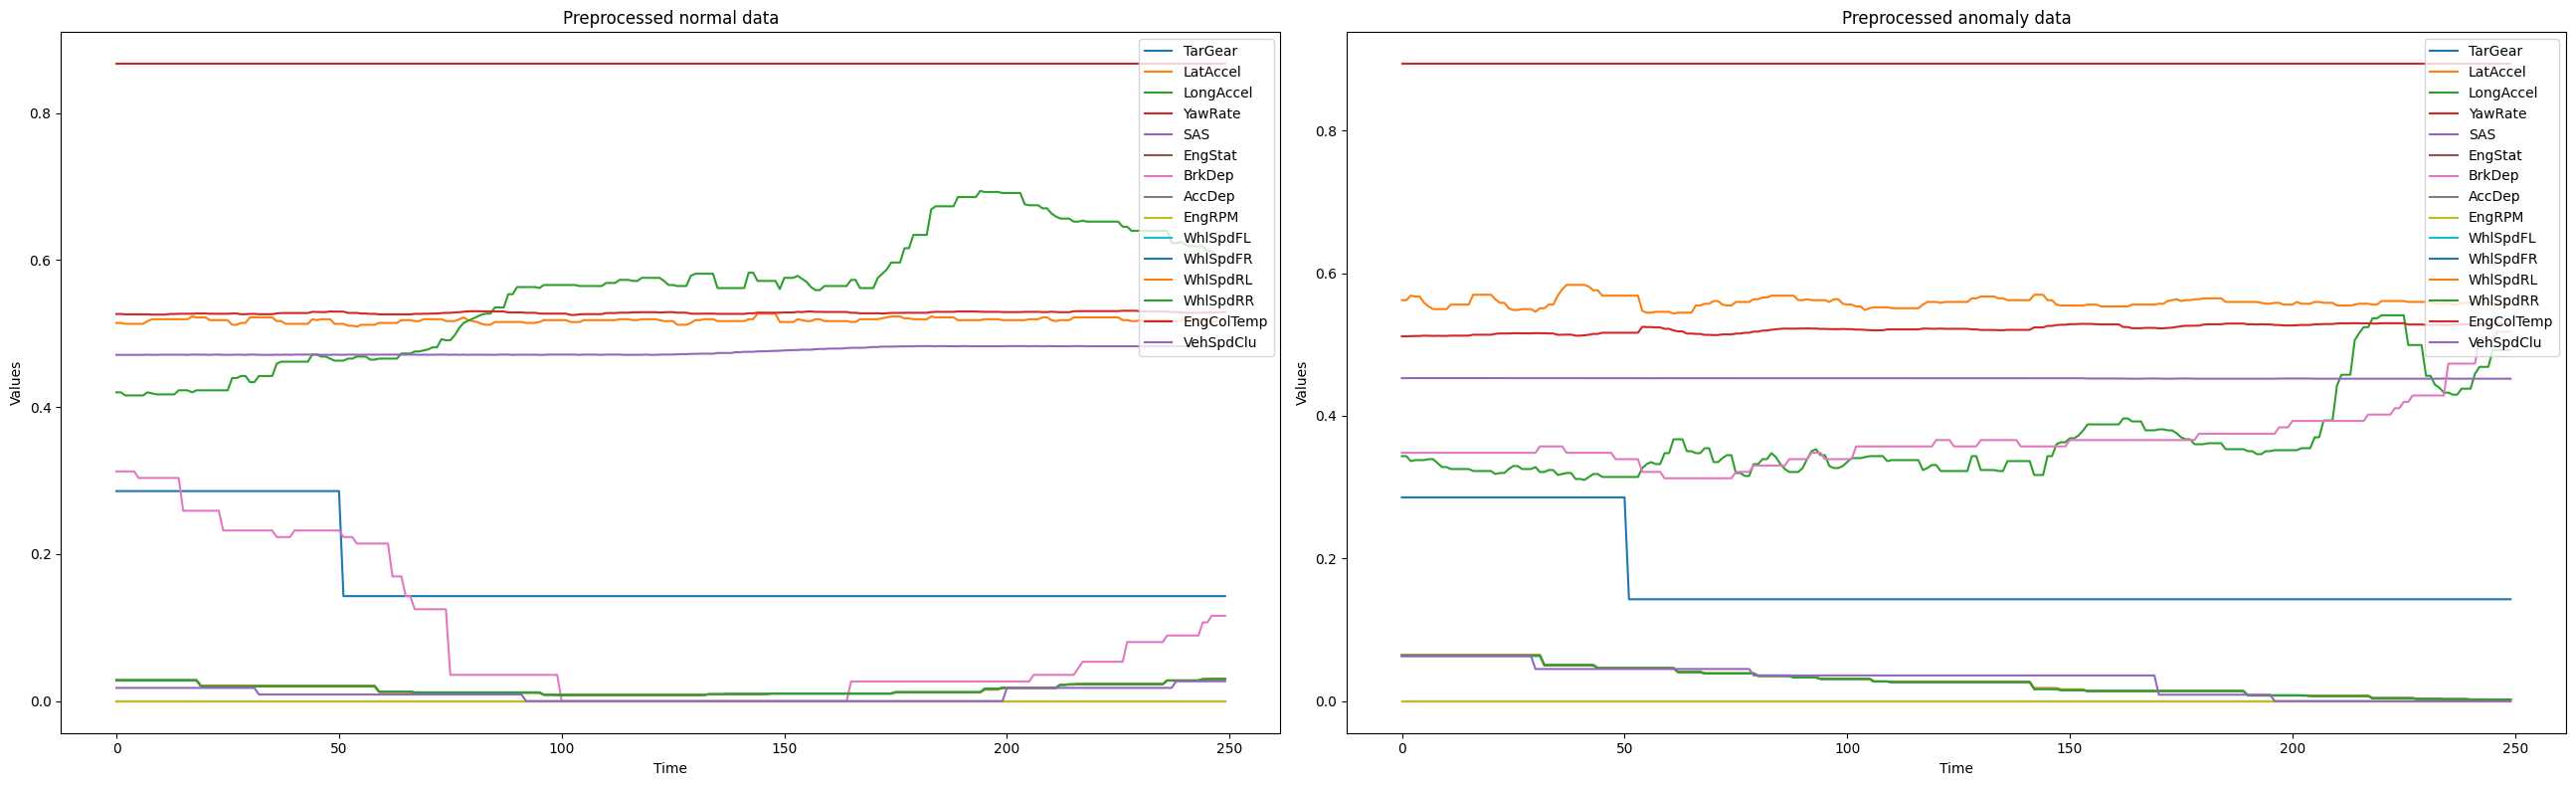

In [62]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(26, 8))

# 전처리 이후 정상데이터 각 열에 대한 그래프
for col in test_list[5].columns:
    axs[0].plot(test_list[5][col], label=col)

axs[0].set_title('Preprocessed normal data')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')
axs[0].legend(loc='upper right')

# 전처리 이후 비정상데이터 각 열에 대한 그래프
for col in test_list[21].columns:
    axs[1].plot(test_list[21][col], label=col)

axs[1].set_title('Preprocessed anomaly data')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Values')
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


In [63]:
num = int(len(Y_test)/2) # 정상 및 이상 데이터 개수
Y_test

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

### **평가 및 시각화**

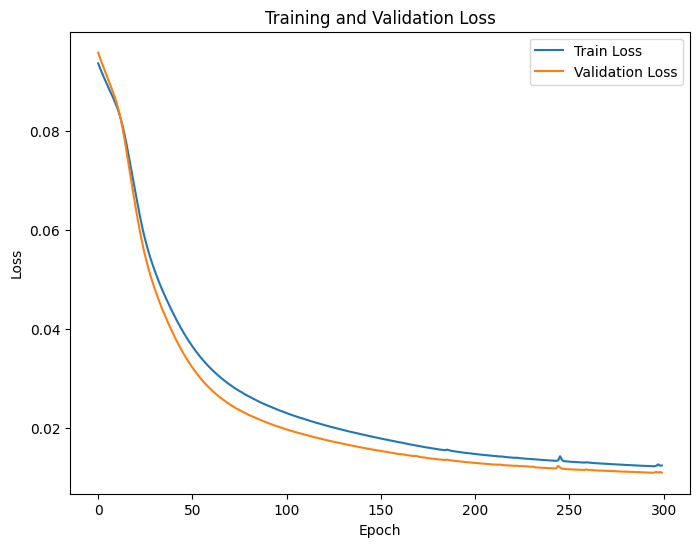

In [103]:
# 학습 loss 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [98]:
def visualize_anomaly_detection(df_can_test, df_can_test_normal, df_can_test_anomaly):
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))

    # anomaly_score Histogram
    axs[0].hist(df_can_test_normal['anomaly_score'], bins=50,  label='GT False')
    axs[0].hist(df_can_test_anomaly['anomaly_score'], bins=50, alpha=0.8, label='GT True')
    axs[0].set_xlabel('Anomaly Score')
    axs[0].set_ylabel('# of examples')
    axs[0].legend(loc='upper right')

    # anomaly_score Box Plot
    data = [df_can_test_anomaly['anomaly_score'], df_can_test_normal['anomaly_score']]
    labels = ['Anomaly', 'Normal']
    axs[1].boxplot(data, labels=labels, vert=False)
    axs[1].set_yticklabels(labels, rotation=90)
    axs[1].set_xlabel('Anomaly Score')
    axs[1].set_ylabel('Data Type')

    plt.tight_layout()
    plt.show()

In [99]:
reconstructions = autoencoder.predict(scaled_test_data)
anomaly_score = tf.keras.losses.mse(reconstructions, scaled_test_data)

1/1 [==============================] - 0s 39ms/step


In [100]:
# 250차원을 따라 anomaly_score 평균 계산
average_anomaly_score = tf.reduce_mean(anomaly_score, axis=1)

# NumPy 배열로 변환
average_anomaly_score_numpy = average_anomaly_score.numpy()

# 데이터프레임으로 변환
df_test_anomaly_score = pd.DataFrame(average_anomaly_score_numpy, columns=['anomaly_score'])

# 정상 데이터와 이상치 데이터 분리
df_can_test_normal = df_test_anomaly_score[:num]
df_can_test_anomaly = df_test_anomaly_score[num:]

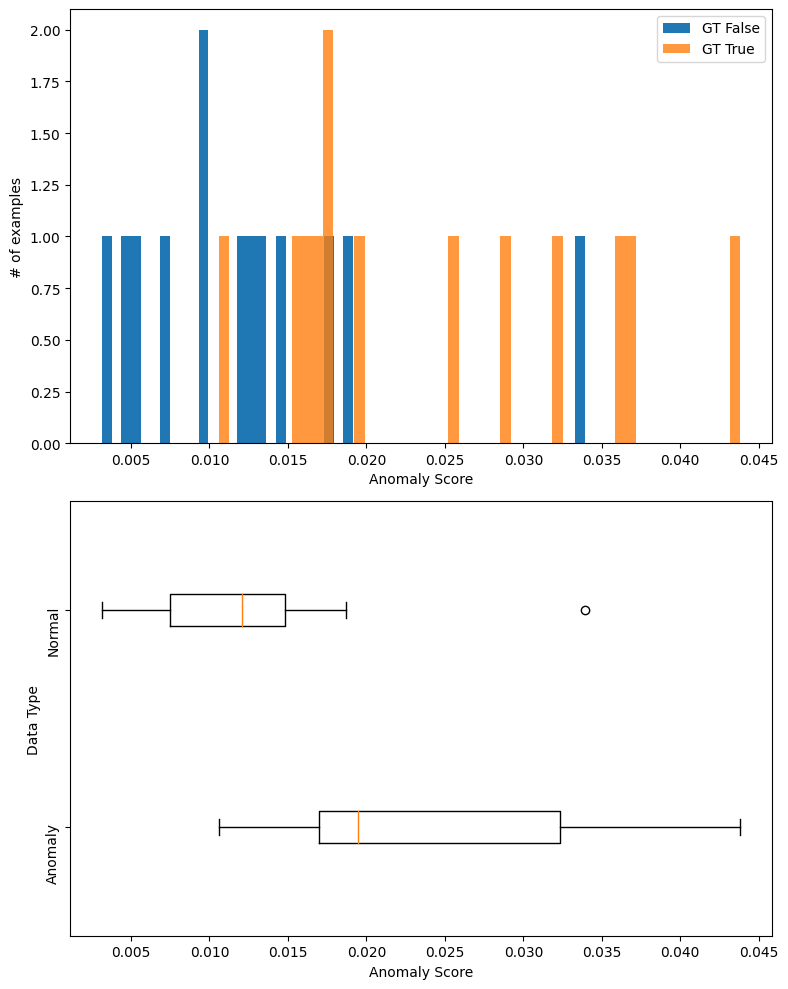

In [101]:
# 시각화
visualize_anomaly_detection(df_test_anomaly_score, df_can_test_normal, df_can_test_anomaly)

AUC =0.8579881656804734


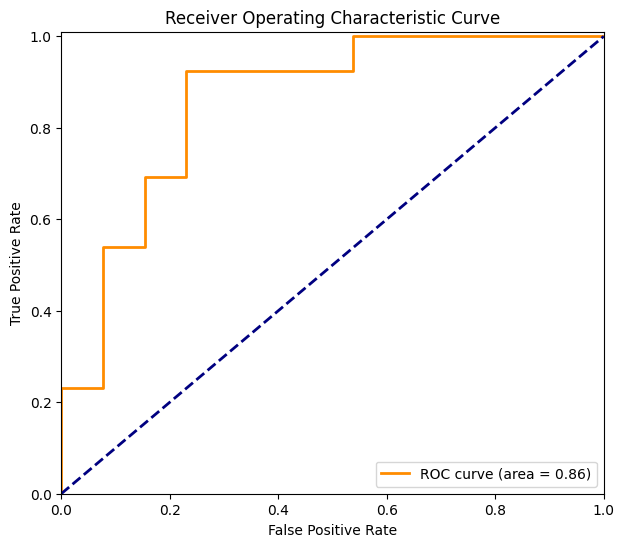

In [110]:
from sklearn.metrics import roc_curve, auc
# FPR, TPR, threshold 계산
fpr, tpr, thresholds = roc_curve(Y_test, average_anomaly_score_numpy)

#Area Under Curve(AUROC) 계산
roc_auc = auc(fpr, tpr)

print(f"AUC ={roc_auc}")

# ROC 커브
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
